In [1]:
import pickle

import matplotlib
matplotlib.use('Agg')
import os
import datetime
import numpy as np
import dill as pickle
import random
import sys
np.random.seed(0)
random.seed(0)
now = datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)
#print(os.getcwd())
from codes.experimentclasses.RigidEthanolPCA import RigidEthanolPCA
from codes.otherfunctions.multirun import get_coeffs_reps_tangent
from codes.otherfunctions.multirun import get_grads_reps_pca2_tangent
from codes.otherfunctions.multiplot import plot_reg_path_ax_lambdasearch_tangent
from codes.otherfunctions.get_dictionaries import get_atoms_4
from codes.flasso.Replicate import Replicate
from codes.otherfunctions.get_grads_tangent import get_grads_tangent
from codes.otherfunctions.multirun import get_support_recovery_lambda
from codes.otherfunctions.multirun import get_lower_interesting_lambda
import matplotlib.pyplot as plt
from codes.otherfunctions.multirun import get_coeffs_and_lambdas
from codes.geometer.RiemannianManifold import RiemannianManifold
from collections import Counter

/Users/samsonkoelle/manifoldflasso_jmlr


In [55]:

def plot_reg_path_ax_lambdasearch_customcolors(axes, coeffs, xaxis,fig, colors):
    p = coeffs.shape[3]
    q = coeffs.shape[1]
    gnames = np.asarray(list(range(p)), dtype=str)

    # xlabel = r"$\displaystyle \lambda$"
    # ylabel = r"$\displaystyle \|\hat \beta_{j}\|_2$"
    rcParams['axes.titlesize'] = 30
    plt.rc('text', usetex=True)

    # maxes = np.zeros(q)
    # for k in range(q):
    #     maxes[k] = np.linalg.norm(coeffs[:, k, :, :], axis=1).max()
    # normax = maxes.max()
    normax = np.sqrt(np.sum(np.sum(np.sum(coeffs ** 2, axis=1), axis=1), axis=1).max())

    for k in range(q):
        for j in range(p):
            toplot = np.linalg.norm(coeffs[:, k, :, j], axis=1)
            w = .15
            widths = np.asarray([width(xaxis[i], w) for i in range(len(xaxis))])
            # axes[k+1].boxplot(toplot, positions=xaxis, showfliers=False, vert=True, widths=widths,medianprops=dict(linestyle=''))
            axes[k + 1].plot(xaxis, toplot, 'go--', linewidth=5, markersize=0, alpha=1.,
                             color=colors[j], label=gnames[j])
    for j in range(p):
        toplot = np.linalg.norm(np.linalg.norm(coeffs[:, :, :, j], axis=2), axis=1)
        # axes[0].boxplot(toplot, positions=xaxis, showfliers=False, vert=True, widths=widths,medianprops=dict(linestyle=''))
        axes[0].plot(xaxis, toplot, 'go--', linewidth=5, markersize=0, alpha=1.,
                     color=colors[j], label=gnames[j])

    kkk = xaxis.copy()
    kkk.sort()

    # xupperindex = np.min(np.where(np.sum(np.sum(np.sum(coeffs**2, axis = 1), axis = 1), axis = 1) ==0)[0])

    for k in range(1 + q):
        axes[k].tick_params(labelsize=50)
        axes[k].set_xscale('symlog')
        axes[k].set_yscale('symlog')
        axes[k].set_ylim(bottom=0, top=normax)
        # axes[k].set_xlim(left = 0, right = xaxis[xupperindex])
        if (k == 0):
            tixx = np.hstack(
                [np.asarray([0]), 10 ** np.linspace(math.floor(np.log10(normax)), math.floor(np.log10(normax)) + 1, 2)])
        if k != 0:
            # axes[k].set_yticks(tixx)
            axes[k].set_yticklabels([])
        if k != q:
            axes[k+1].set_title(r"$\phi_{{{}}}$".format(k+1), fontsize = 50)
            #axes[k + 1].set_title(r"$\phi_{{{}}}$.format(k)")
        if k == 0:
            axes[k].set_title("Combined", fontdict={'fontsize': 50})
    for k in range(1 + q):
        axes[k].grid(True, which="both", alpha=True)
        axes[k].set_xlabel(r"$\lambda$", fontsize = 50)
        axes[k].set_xticklabels([])
        axes[k].set_xticks([])
        
    axes[0].set_ylabel(r"$||\beta_j||$", fontsize = 50)
        
#     handles, labels = axes[0].get_legend_handles_labels()
#     by_label = OrderedDict(zip(labels, handles))
#     # fig.text(0.5, 0.04, xlabel, ha='center', va='center', fontsize=50)
#     # fig.text(0.05, 0.5, ylabel, ha='center', va='center', rotation='vertical', fontsize=60)
#     fig.subplots_adjust(right=0.75)
#     leg_ax = fig.add_axes([.8, 0.15, 0.05, 0.7])
#     leg_ax.axis('off')
#     leg = leg_ax.legend(by_label.values(), gnames, prop={'size': 200 / p})
#     # leg.set_title('Torsion', prop={'size': Function})
#     for l in leg.get_lines():
#         l.set_alpha(1)
    # fig.savefig(filename + 'beta_paths_n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(
    #    nreps))



In [3]:
swiss_ltsa =np.load('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/untracked_data/embeddings/swiss_ltsa.npy')
swiss_internal = np.load('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/untracked_data/embeddings/swiss_internal.npy')
swiss_isomap = np.load('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/untracked_data/embeddings/swiss_isomap.npy')
swiss_spectral = np.load('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/untracked_data/embeddings/swiss_spectral.npy')

In [4]:
with open('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/untracked_data/embeddings/swiss_spectral.pkl' ,
        'rb') as output:
    replicates_swiss_spectral = pickle.load(output)
    
with open('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/untracked_data/embeddings/swiss_isomap.pkl' ,
        'rb') as output:
    replicates_swiss_isomap = pickle.load(output)

with open('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/untracked_data/embeddings/swiss_internal.pkl' ,
        'rb') as output:
    replicates_swiss_internal = pickle.load(output)
with open('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/untracked_data/embeddings/swiss_ltsa.pkl' ,
        'rb') as output:
    replicates_swiss_ltsa = pickle.load(output)


In [32]:
m  = 2
nsel = 50
colors = np.hstack([np.repeat('red',1), np.repeat('blue',1),np.repeat('black',49)])
from pylab import rcParams
def width(p,w):
    if p > 1.:
        output = 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)
    else:
        output = w
    return(output)
import math 
from collections import OrderedDict


# def plot_reg_path_ax_lambdasearch_customcolors_norm(ax, coeffs, xaxis,fig, colors):
#     p = coeffs.shape[3]
#     q = coeffs.shape[1]
#     gnames = np.asarray(list(range(p)), dtype=str)

#     rcParams['axes.titlesize'] = 30
#     plt.rc('text', usetex=True)

#     normax = np.sqrt(np.sum(np.sum(np.sum(coeffs ** 2, axis=1), axis=1), axis=1).max())

#     for j in range(p):
#         toplot = np.linalg.norm(np.linalg.norm(coeffs[:, :, :, j], axis=2), axis=1)
#         # axes[0].boxplot(toplot, positions=xaxis, showfliers=False, vert=True, widths=widths,medianprops=dict(linestyle=''))
#         ax.plot(xaxis, toplot, 'go--', linewidth=5, markersize=0, alpha=1.,
#                      color=colors[j], label=gnames[j])

#     kkk = xaxis.copy()
#     kkk.sort()

#     # xupperindex = np.min(np.where(np.sum(np.sum(np.sum(coeffs**2, axis = 1), axis = 1), axis = 1) ==0)[0])

#     #for k in range(1 + q):
#     ax.tick_params(labelsize=50)
#     ax.set_xscale('symlog')
#     ax.set_yscale('symlog')
#     ax.set_ylim(bottom=0, top=normax)
#     # axes[k].set_xlim(left = 0, right = xaxis[xupperindex])
#     #if (k == 0):
#     tixx = np.hstack(
#         [np.asarray([0]), 10 ** np.linspace(math.floor(np.log10(normax)), math.floor(np.log10(normax)) + 1, 2)])
# #    if k != 0:
#         # axes[k].set_yticks(tixx)
#     #ax.set_ylabel(r"$\displaystyle \|\hat \beta_{j}\|_2$", fontsize = 70)
#     #ax.set_xlabel(r"$\lambda  \sqrt{nm}$", fontsize = 70)
#     #ylabel = r"$\displaystyle \|\hat \beta_{j}\|_2$"
#     #ax.l
#     #if k == 0:
#     #ax.set_title("Combined", fontdict={'fontsize': 50})
#     ax.grid(True, which="both", alpha=True)

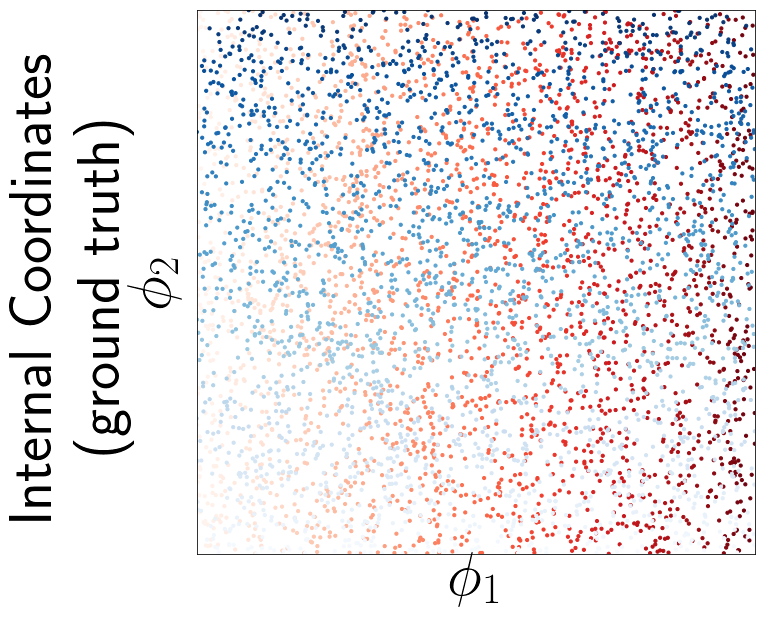

In [54]:
%matplotlib inline
fig, axes_all = plt.subplots(figsize=(10,10) )
inds1 = np.asarray(list(range(2500)))*2
inds2 = np.asarray(list(range(2500)))*2 + 1
axes_all.scatter(swiss_internal[inds1,0],swiss_internal[inds1,1], s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
axes_all.scatter(swiss_internal[inds2,0],swiss_internal[inds2,1], s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')
axes_all.set_xlim(swiss_internal[:,0].min(), swiss_internal[:,0].max())
axes_all.set_ylim(swiss_internal[:,1].min(), swiss_internal[:,1].max())
axes_all.set_xticks([])
axes_all.set_yticks([])
#axes_all[0,0].set_ylabel(r'$\phi_2$')
#axes_all[0,0].set_xlabel(r'$\phi_1$')
axes_all.set_xlabel(r'$\phi_1$', fontsize = 60)
axes_all.set_ylabel(r'$\phi_2$', fontsize = 60)
fig.text(-0.05, 0.5, 'Internal Coordinates \n (ground truth)', ha='center', va='center', rotation='vertical', fontsize = 60)
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/swissroll_internalembed', bbox_inches = "tight")


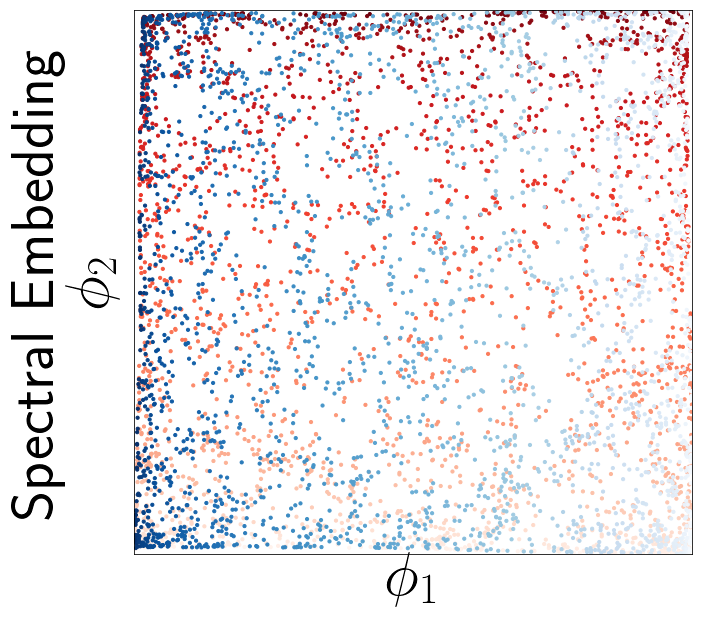

In [51]:
%matplotlib inline
fig, axes_all = plt.subplots(figsize=(10,10) )

axes_all.scatter(swiss_spectral[inds1,0],swiss_spectral[inds1,1], s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
axes_all.scatter(swiss_spectral[inds2,0],swiss_spectral[inds2,1], s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')
axes_all.set_xlim(swiss_spectral[:,0].min(), swiss_spectral[:,0].max())
axes_all.set_ylim(swiss_spectral[:,1].min(), swiss_spectral[:,1].max())
axes_all.set_xticks([])
axes_all.set_yticks([])
#axes_all[1,0].set_ylabel(r'$\phi_2$')
#axes_all[1,0].set_xlabel(r'$\phi_1$')
axes_all.set_xlabel(r'$\phi_1$', fontsize = 60)
axes_all.set_ylabel(r'$\phi_2$', fontsize = 60)
#secax = axes_all[1,0].secondary_yaxis('left')# functions=(deg2rad, rad2deg))
#secax.set_text(x 'Spectral Embedding', labelpad = 20,fontsize = 60)
#axes_all[1,0].set_ylabel(r'$\phi_2$', fontsize = 60, labelpad = 20)
fig.text(-0.01, 0.5, 'Spectral Embedding', ha='center', va='center', rotation='vertical', fontsize = 60)
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/swissroll_spectral', bbox_inches = "tight")


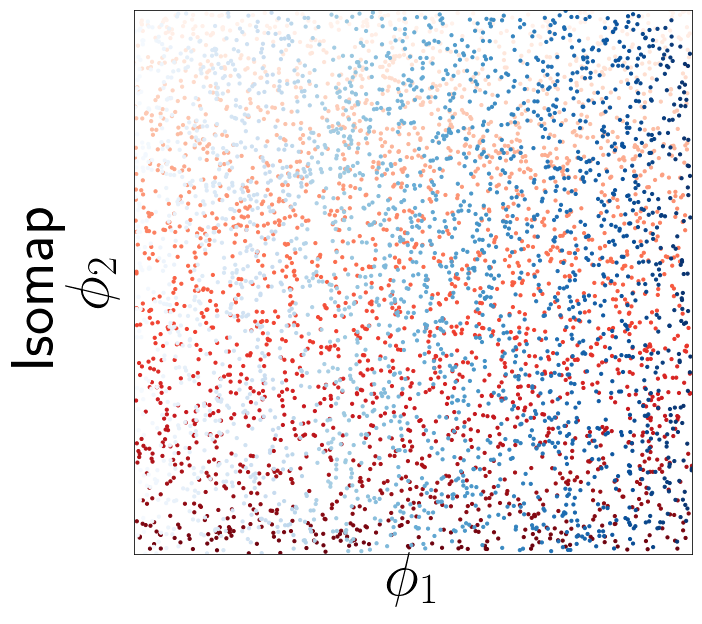

In [52]:
%matplotlib inline
fig, axes_all = plt.subplots(figsize=(10,10) )

axes_all.scatter(swiss_isomap[inds1,0],swiss_isomap[inds1,1], s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
axes_all.scatter(swiss_isomap[inds2,0],swiss_isomap[inds2,1], s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')
axes_all.set_xlim(swiss_isomap[:,0].min(), swiss_isomap[:,0].max())
axes_all.set_ylim(swiss_isomap[:,1].min(), swiss_isomap[:,1].max())
axes_all.set_xticks([])
axes_all.set_yticks([])
#axes_all[2,0].set_ylabel(r'$\phi_2$')
#axes_all[2,0].set_xlabel(r'$\phi_1$')
axes_all.set_xlabel(r'$\phi_1$', fontsize = 60)
axes_all.set_ylabel(r'$\phi_2$', fontsize = 60)
fig.text(-0.01, 0.5, 'Isomap', ha='center', va='center', rotation='vertical', fontsize = 60)
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/sr_isomap', bbox_inches = "tight")


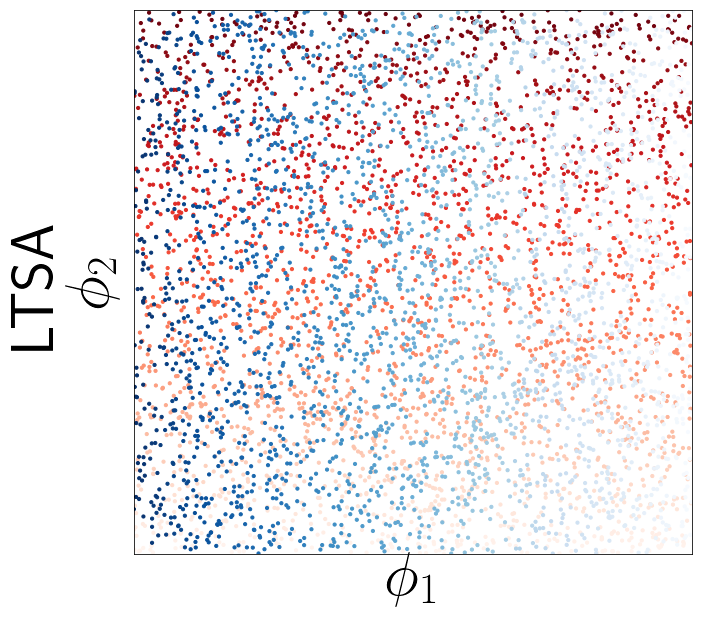

In [53]:
%matplotlib inline
fig, axes_all = plt.subplots(figsize=(10,10) )

axes_all.scatter(swiss_ltsa[inds1,0],swiss_ltsa[inds1,1], s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
axes_all.scatter(swiss_ltsa[inds2,0],swiss_ltsa[inds2,1], s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')
axes_all.set_xlim(swiss_ltsa[:,0].min(), swiss_ltsa[:,0].max())
axes_all.set_ylim(swiss_ltsa[:,1].min(), swiss_ltsa[:,1].max())
axes_all.set_xticks([])
axes_all.set_yticks([])
#axes_all[3,0].set_ylabel(r'$\phi_2$')
axes_all.set_xlabel(r'$\phi_1$', fontsize = 60)
axes_all.set_ylabel(r'$\phi_2$', fontsize = 60)
fig.text(-0.01, 0.5, 'LTSA', ha='center', va='center', rotation='vertical', fontsize = 60)

plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/sr_ltsa', bbox_inches = "tight")



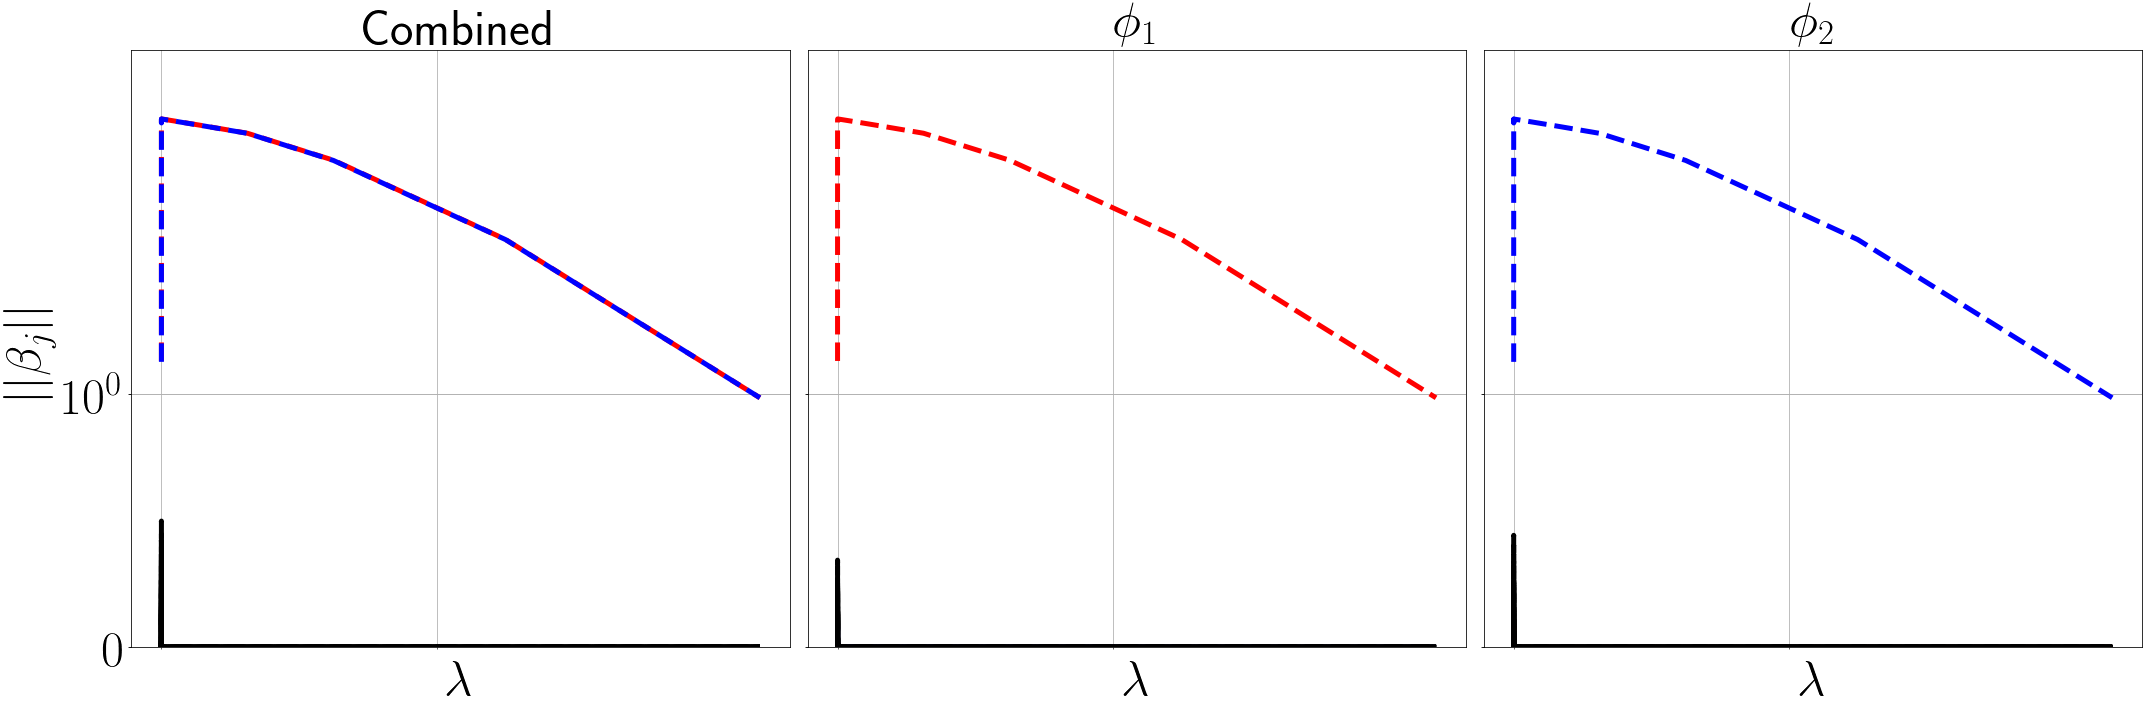

In [57]:
%matplotlib inline
fig, axes_all = plt.subplots(1,3, figsize=(30,10) )

plot_reg_path_ax_lambdasearch_customcolors(axes_all, replicates_swiss_internal[0].coeffs, replicates_swiss_internal[0].lambdas_plot * np.sqrt(m * nsel), fig,colors)
#axes_all.colorbar('off')
plt.tight_layout()
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/sr_internal_mflasso', bbox_inches = "tight")


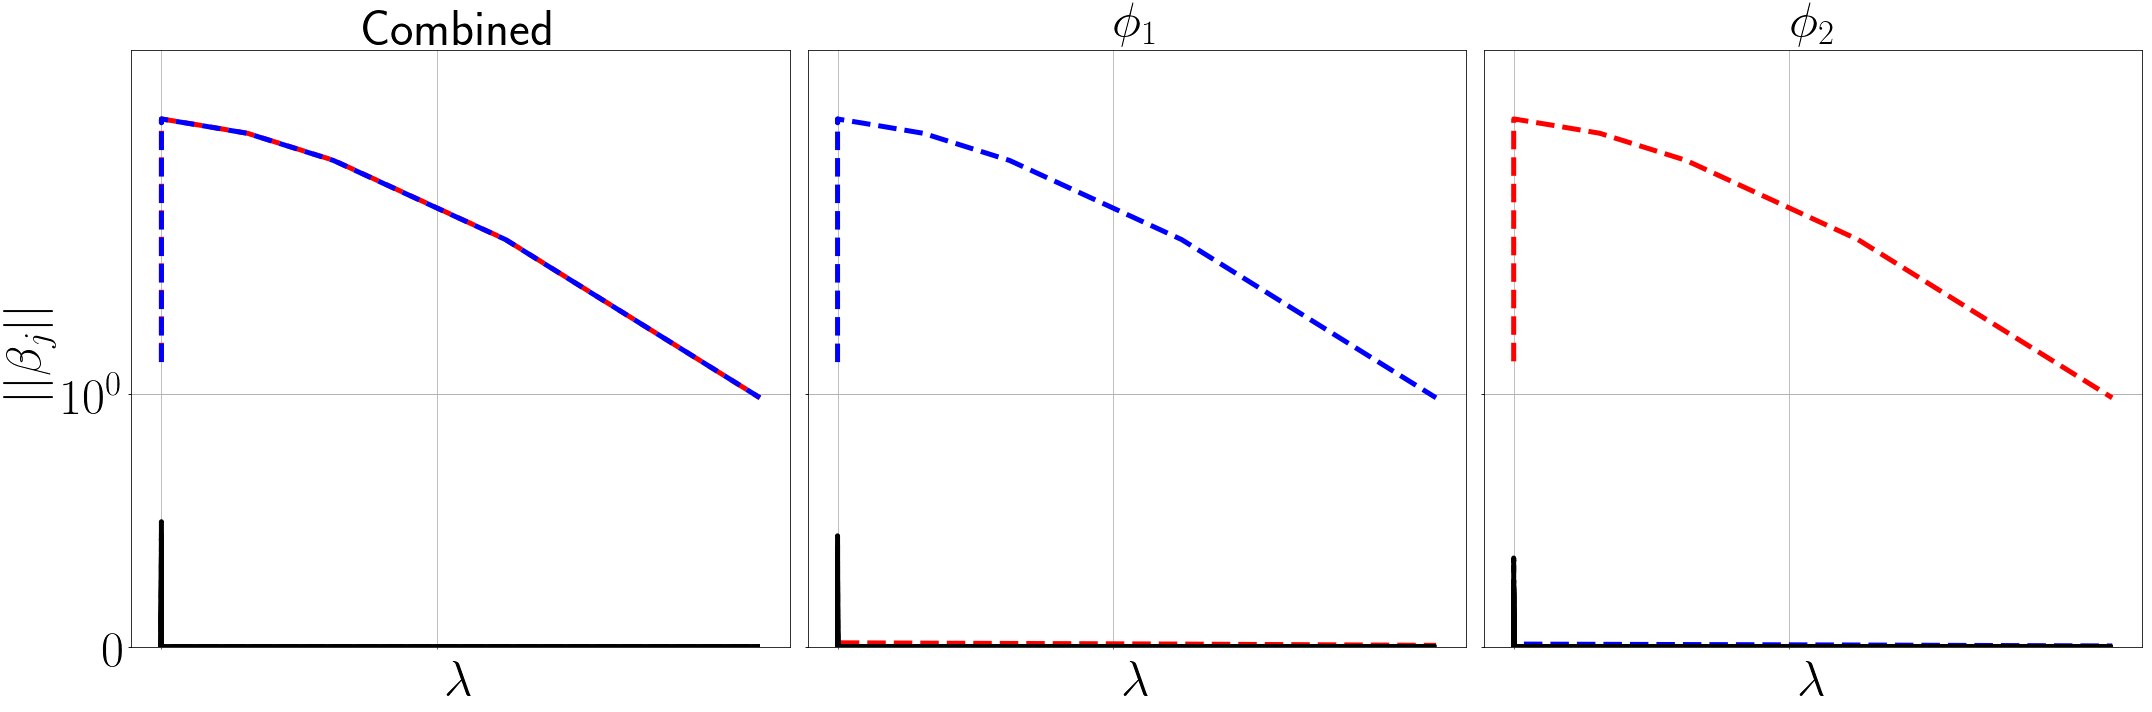

In [58]:
%matplotlib inline
fig, axes_all = plt.subplots(1,3, figsize=(30,10) )

plot_reg_path_ax_lambdasearch_customcolors(axes_all, replicates_swiss_isomap[0].coeffs, replicates_swiss_isomap[0].lambdas_plot * np.sqrt(m * nsel), fig,colors)
#axes_all.colorbar('off')
plt.tight_layout()
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/sr_isomap_mflasso', bbox_inches = "tight")


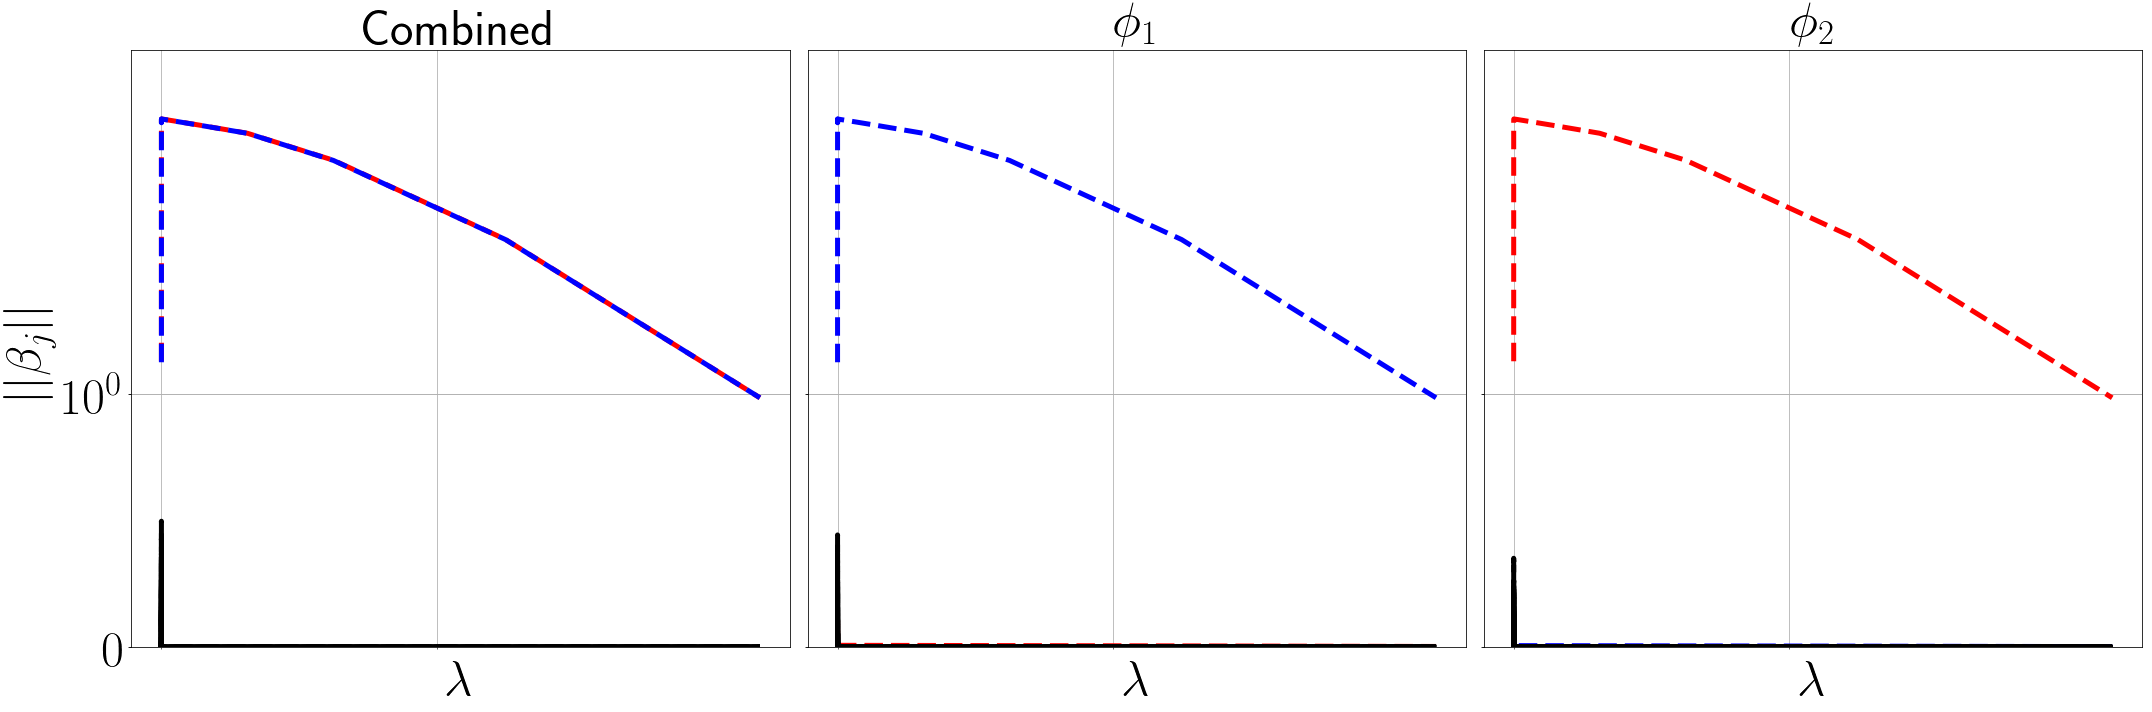

In [59]:
%matplotlib inline
fig, axes_all = plt.subplots(1,3, figsize=(30,10) )

plot_reg_path_ax_lambdasearch_customcolors(axes_all, replicates_swiss_ltsa[0].coeffs, replicates_swiss_ltsa[0].lambdas_plot * np.sqrt(m * nsel), fig,colors)
#axes_all.colorbar('off')
plt.tight_layout()
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/sr_ltsa_mflasso', bbox_inches = "tight")


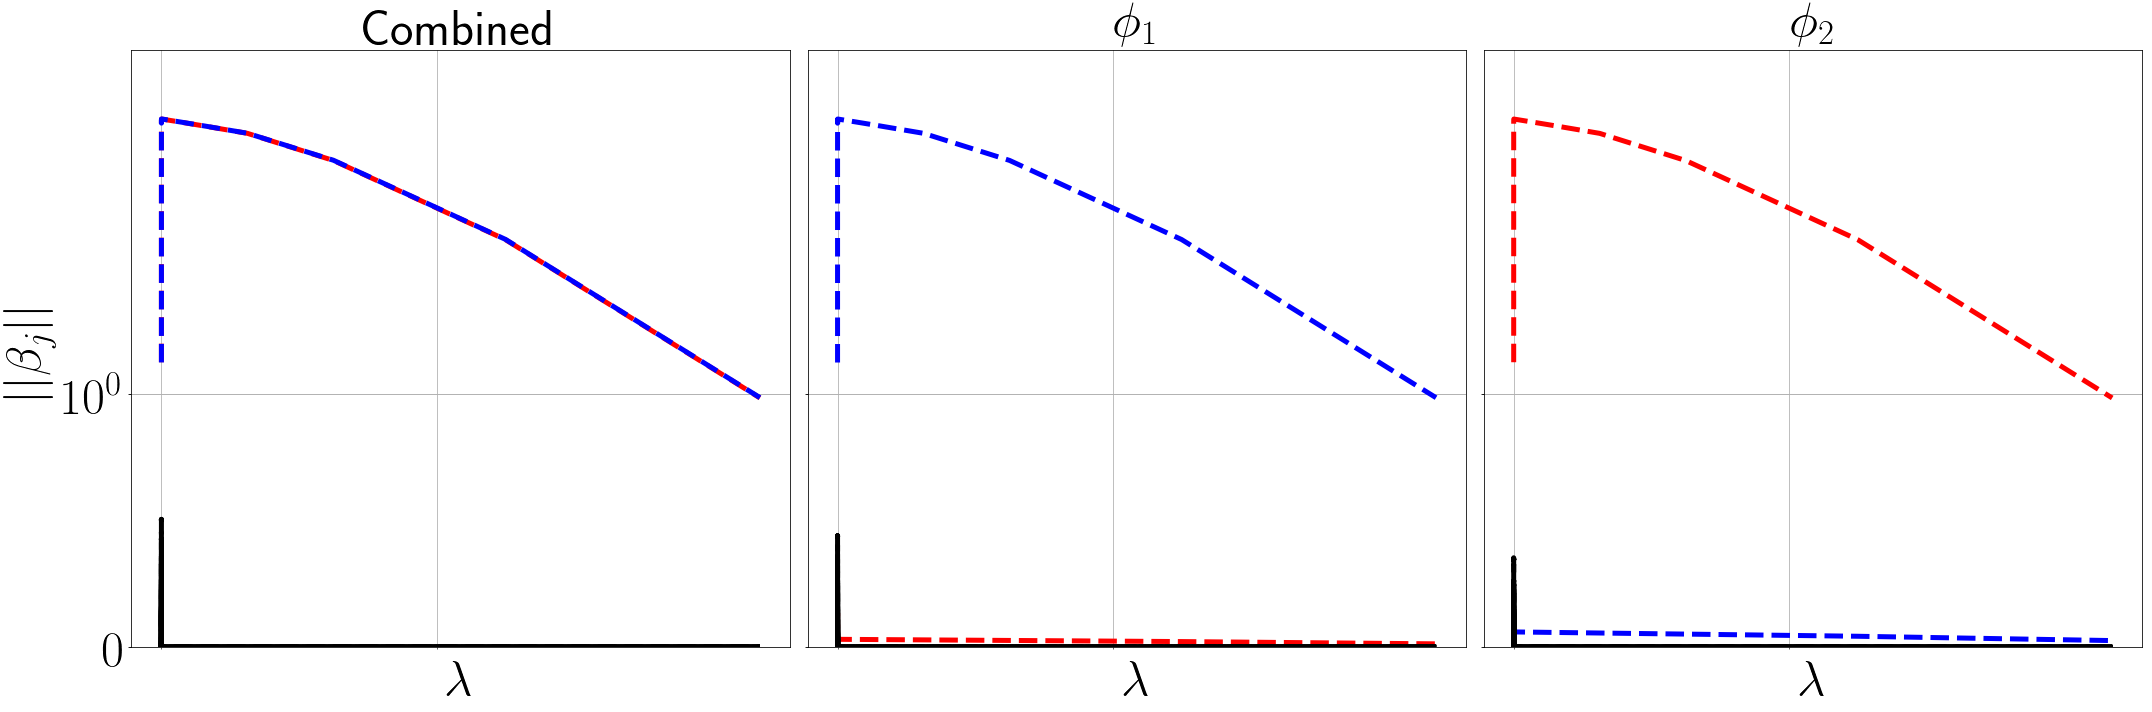

In [60]:
%matplotlib inline
fig, axes_all = plt.subplots(1,3, figsize=(30,10) )

plot_reg_path_ax_lambdasearch_customcolors(axes_all, replicates_swiss_spectral[0].coeffs, replicates_swiss_spectral[0].lambdas_plot * np.sqrt(m * nsel), fig,colors)

plt.tight_layout()
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/sr_spectral_mflasso', bbox_inches = "tight")


In [ ]:
f, axarr = plt.subplots(1,1,figsize=(10, 10))
#axarr.set_axis_off() 
mpl.style.use('default')
plot_reg_path_ax_lambdasearch_customcolors_norm(axarr, cs_reorder, xaxis_reorder * np.sqrt(3 * 5), f,colors)#axes_all[0].imshow(asdf)
axarr.set_xlabel(r'$\lambda$', fontsize = 30)
axarr.set_ylabel(r'$||\beta_j||$', fontsize = 30)

axarr.axvline(xaxis_reorder[1] * np.sqrt(3 * 5), color = 'black')
axarr.text(xaxis_reorder[1] * np.sqrt(3 * 5), 1.5, r'$\lambda_{-1}$', fontsize = 40)
axarr.axvline(xaxis_reorder[2] * np.sqrt(3 * 5), color = 'black')
axarr.text(xaxis_reorder[2] * np.sqrt(3 * 5), 1.5, r'$\lambda_{0}$', fontsize = 40)
axarr.set_title('Regularization path (single replicate)')
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/eth_fulldict_replicate')

#axarr.patch.set_facecolor('None')

In [ ]:
%matplotlib inline
fig, axes_all = plt.subplots(4, 4,figsize=(45,45) )#15*nreps))
inds1 = np.asarray(list(range(2500)))*2
inds2 = np.asarray(list(range(2500)))*2 + 1
axes_all[0,0].scatter(swiss_internal[inds1,0],swiss_internal[inds1,1], s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
axes_all[0,0].scatter(swiss_internal[inds2,0],swiss_internal[inds2,1], s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')
axes_all[0,0].set_xlim(swiss_internal[:,0].min(), swiss_internal[:,0].max())
axes_all[0,0].set_ylim(swiss_internal[:,1].min(), swiss_internal[:,1].max())
axes_all[0,0].set_xticks([])
axes_all[0,0].set_yticks([])
#axes_all[0,0].set_ylabel(r'$\phi_2$')
#axes_all[0,0].set_xlabel(r'$\phi_1$')
axes_all[0,0].set_xlabel(r'$\phi_1$', fontsize = 60)
axes_all[0,0].set_ylabel(r'$\phi_2$', fontsize = 60)
fig.text(-0.01, 0.9, 'Internal Coordinates \n (ground truth)', ha='center', va='center', rotation='vertical', fontsize = 60)


axes_all[1,0].scatter(swiss_spectral[inds1,0],swiss_spectral[inds1,1], s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
axes_all[1,0].scatter(swiss_spectral[inds2,0],swiss_spectral[inds2,1], s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')
axes_all[1,0].set_xlim(swiss_spectral[:,0].min(), swiss_spectral[:,0].max())
axes_all[1,0].set_ylim(swiss_spectral[:,1].min(), swiss_spectral[:,1].max())
axes_all[1,0].set_xticks([])
axes_all[1,0].set_yticks([])
#axes_all[1,0].set_ylabel(r'$\phi_2$')
#axes_all[1,0].set_xlabel(r'$\phi_1$')
axes_all[1,0].set_xlabel(r'$\phi_1$', fontsize = 60)
axes_all[1,0].set_ylabel(r'$\phi_2$', fontsize = 60)
#secax = axes_all[1,0].secondary_yaxis('left')# functions=(deg2rad, rad2deg))
#secax.set_text(x 'Spectral Embedding', labelpad = 20,fontsize = 60)
#axes_all[1,0].set_ylabel(r'$\phi_2$', fontsize = 60, labelpad = 20)
fig.text(-0.01, 0.64, 'Spectral Embedding', ha='center', va='center', rotation='vertical', fontsize = 60)

axes_all[2,0].scatter(swiss_isomap[inds1,0],swiss_isomap[inds1,1], s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
axes_all[2,0].scatter(swiss_isomap[inds2,0],swiss_isomap[inds2,1], s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')
axes_all[2,0].set_xlim(swiss_isomap[:,0].min(), swiss_isomap[:,0].max())
axes_all[2,0].set_ylim(swiss_isomap[:,1].min(), swiss_isomap[:,1].max())
axes_all[2,0].set_xticks([])
axes_all[2,0].set_yticks([])
#axes_all[2,0].set_ylabel(r'$\phi_2$')
#axes_all[2,0].set_xlabel(r'$\phi_1$')
axes_all[2,0].set_xlabel(r'$\phi_1$', fontsize = 60)
axes_all[2,0].set_ylabel(r'$\phi_2$', fontsize = 60)
fig.text(-0.01, 0.38, 'Isomap', ha='center', va='center', rotation='vertical', fontsize = 60)

axes_all[3,0].scatter(swiss_ltsa[inds1,0],swiss_ltsa[inds1,1], s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
axes_all[3,0].scatter(swiss_ltsa[inds2,0],swiss_ltsa[inds2,1], s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')
axes_all[3,0].set_xlim(swiss_ltsa[:,0].min(), swiss_ltsa[:,0].max())
axes_all[3,0].set_ylim(swiss_ltsa[:,1].min(), swiss_ltsa[:,1].max())
axes_all[3,0].set_xticks([])
axes_all[3,0].set_yticks([])
#axes_all[3,0].set_ylabel(r'$\phi_2$')
axes_all[3,0].set_xlabel(r'$\phi_1$', fontsize = 60)
axes_all[3,0].set_ylabel(r'$\phi_2$', fontsize = 60)
fig.text(-0.01, 0.14, 'LTSA', ha='center', va='center', rotation='vertical', fontsize = 60)

#axes_all[1,0].plot(swiss_spectral)
#axes_all[2,0].plot(swiss_isomap)
#axes_all[3,0].plot(swiss_ltsa)

plot_reg_path_ax_lambdasearch_customcolors(axes_all[0][1:], replicates_swiss_internal[0].coeffs, replicates_swiss_internal[0].lambdas_plot * np.sqrt(m * nsel), fig,colors)
plot_reg_path_ax_lambdasearch_customcolors(axes_all[1][1:], replicates_swiss_spectral[0].coeffs, replicates_swiss_spectral[0].lambdas_plot * np.sqrt(m * nsel), fig,colors)
plot_reg_path_ax_lambdasearch_customcolors(axes_all[2][1:], replicates_swiss_isomap[0].coeffs, replicates_swiss_isomap[0].lambdas_plot * np.sqrt(m * nsel), fig,colors)
plot_reg_path_ax_lambdasearch_customcolors(axes_all[3][1:], replicates_swiss_ltsa[0].coeffs, replicates_swiss_ltsa[0].lambdas_plot * np.sqrt(m * nsel), fig,colors)

fig.tight_layout()

plt.savefig('swissroll_mflasso2', bbox_inches = "tight")

/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


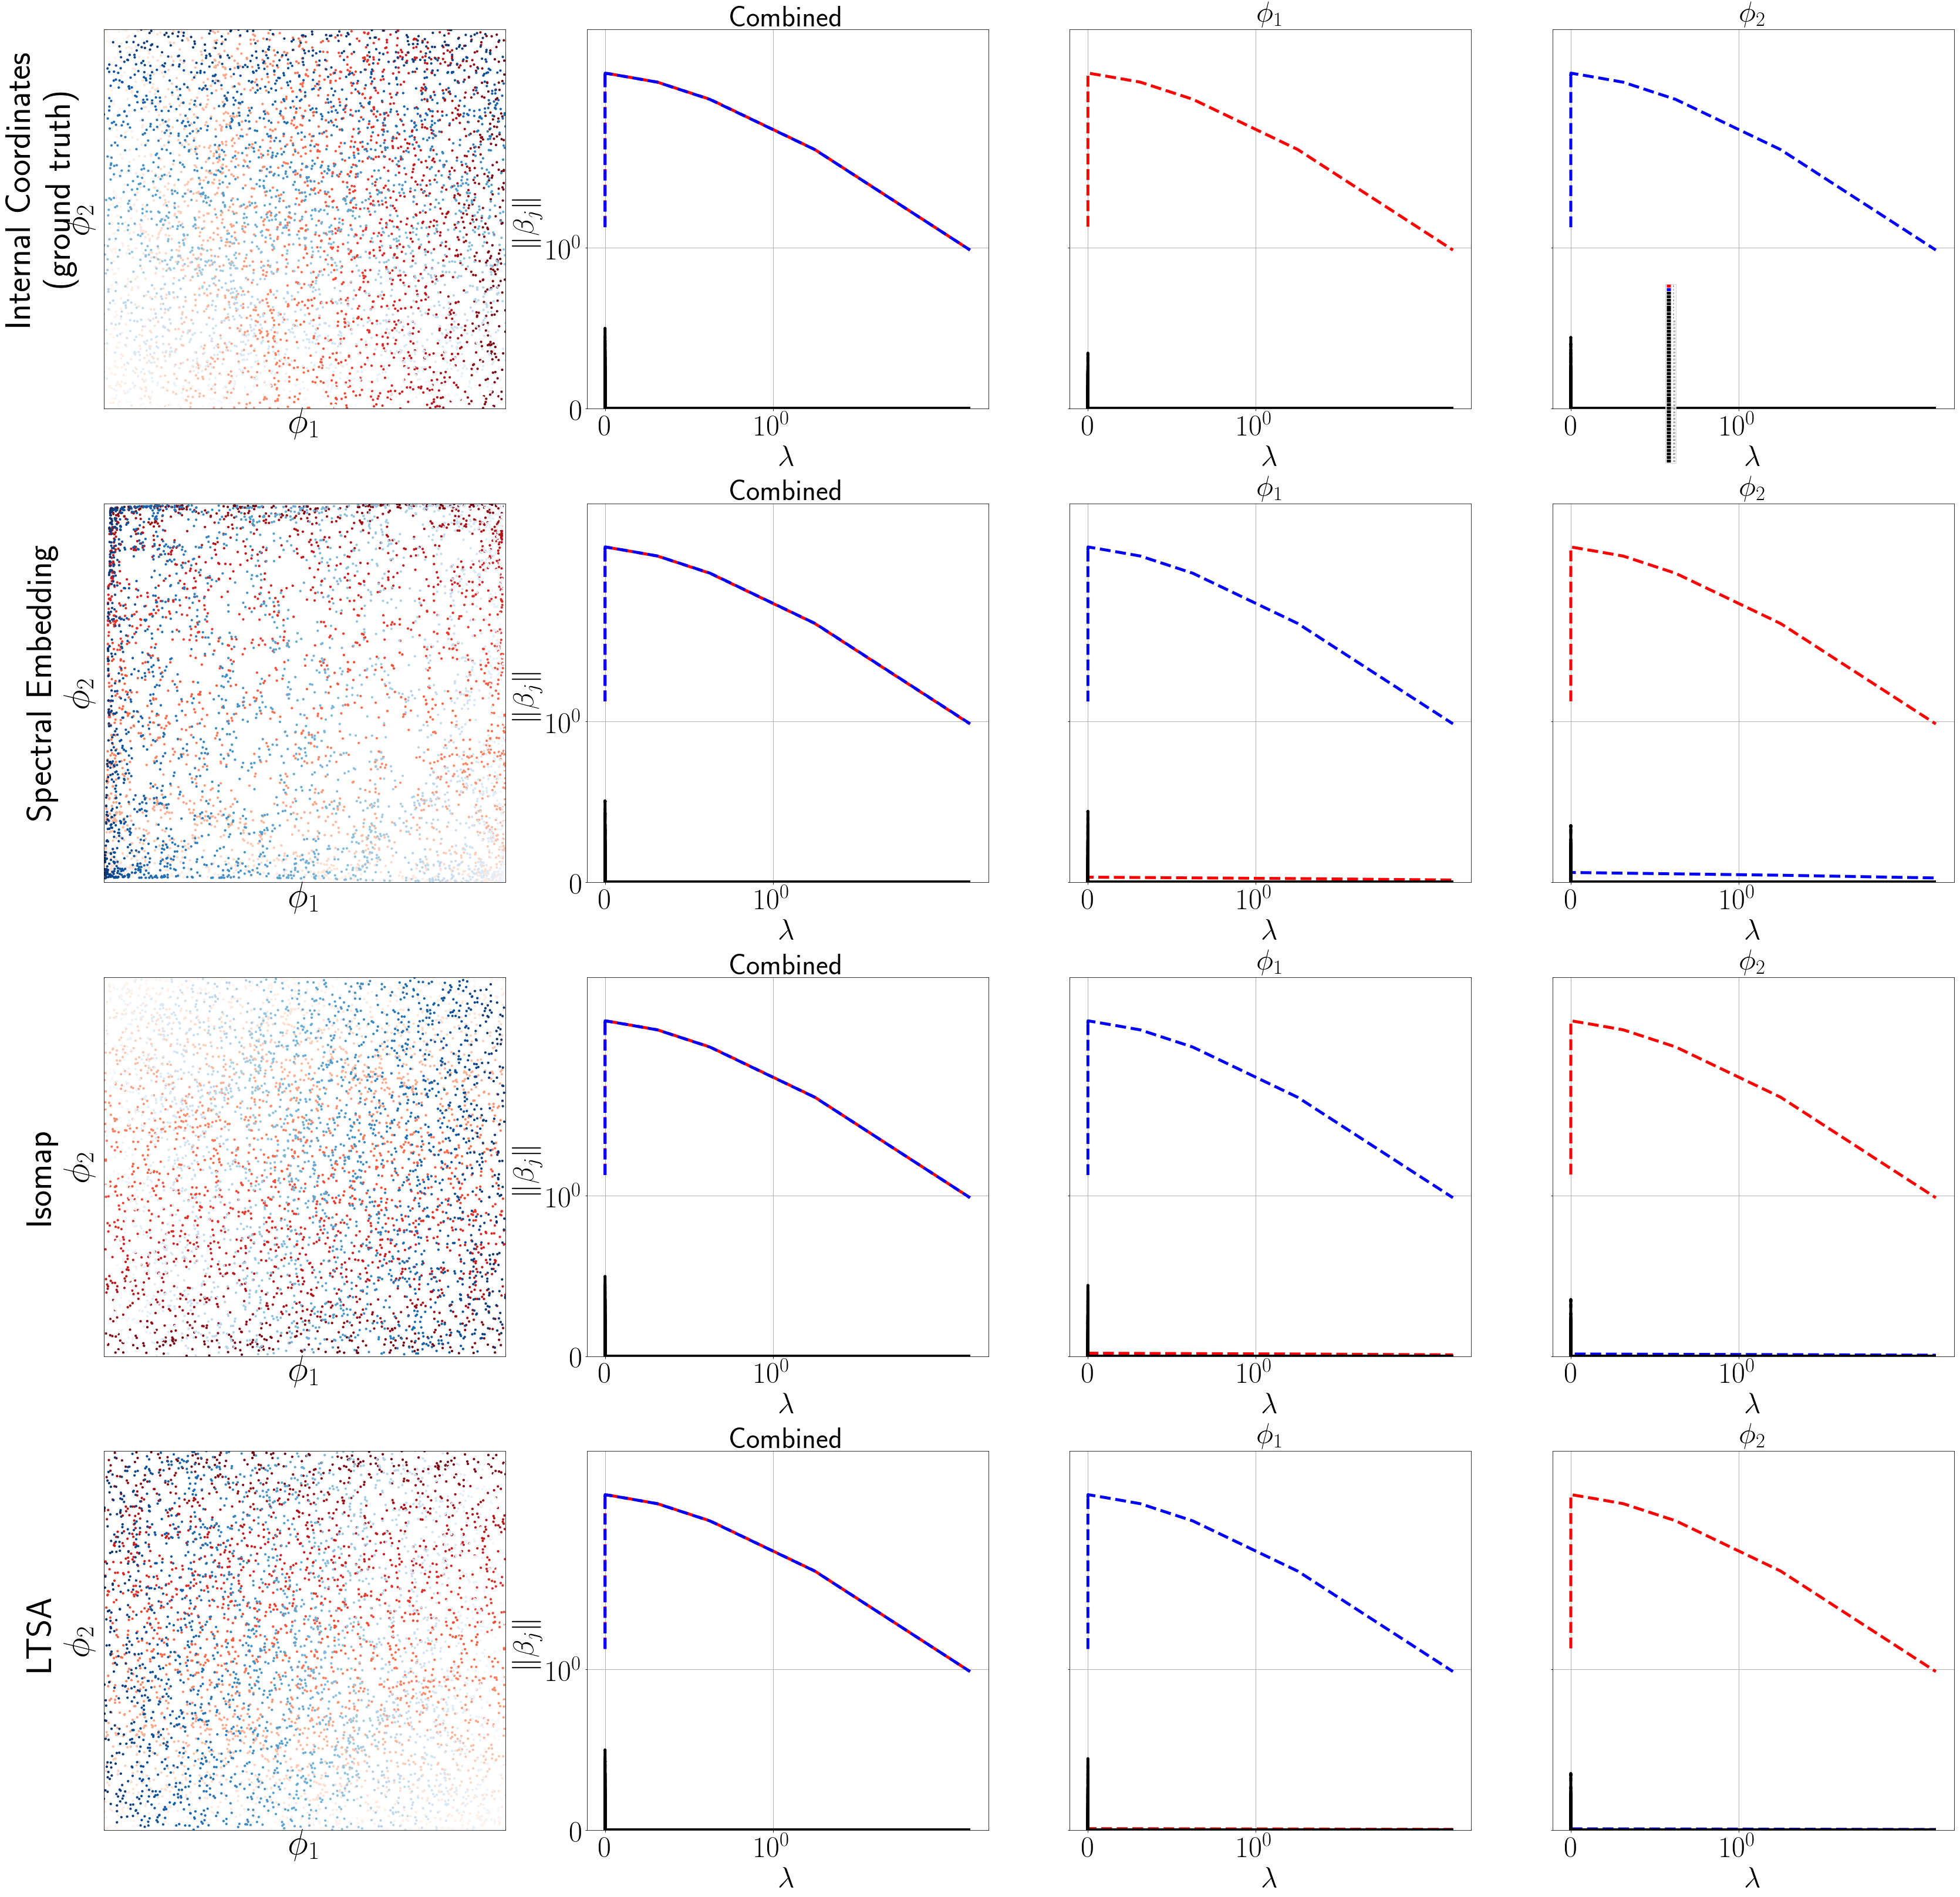

In [29]:
%matplotlib inline
fig, axes_all = plt.subplots(4, 4,figsize=(45,45) )#15*nreps))
inds1 = np.asarray(list(range(2500)))*2
inds2 = np.asarray(list(range(2500)))*2 + 1
axes_all[0,0].scatter(swiss_internal[inds1,0],swiss_internal[inds1,1], s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
axes_all[0,0].scatter(swiss_internal[inds2,0],swiss_internal[inds2,1], s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')
axes_all[0,0].set_xlim(swiss_internal[:,0].min(), swiss_internal[:,0].max())
axes_all[0,0].set_ylim(swiss_internal[:,1].min(), swiss_internal[:,1].max())
axes_all[0,0].set_xticks([])
axes_all[0,0].set_yticks([])
#axes_all[0,0].set_ylabel(r'$\phi_2$')
#axes_all[0,0].set_xlabel(r'$\phi_1$')
axes_all[0,0].set_xlabel(r'$\phi_1$', fontsize = 60)
axes_all[0,0].set_ylabel(r'$\phi_2$', fontsize = 60)
fig.text(-0.01, 0.9, 'Internal Coordinates \n (ground truth)', ha='center', va='center', rotation='vertical', fontsize = 60)


axes_all[1,0].scatter(swiss_spectral[inds1,0],swiss_spectral[inds1,1], s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
axes_all[1,0].scatter(swiss_spectral[inds2,0],swiss_spectral[inds2,1], s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')
axes_all[1,0].set_xlim(swiss_spectral[:,0].min(), swiss_spectral[:,0].max())
axes_all[1,0].set_ylim(swiss_spectral[:,1].min(), swiss_spectral[:,1].max())
axes_all[1,0].set_xticks([])
axes_all[1,0].set_yticks([])
#axes_all[1,0].set_ylabel(r'$\phi_2$')
#axes_all[1,0].set_xlabel(r'$\phi_1$')
axes_all[1,0].set_xlabel(r'$\phi_1$', fontsize = 60)
axes_all[1,0].set_ylabel(r'$\phi_2$', fontsize = 60)
#secax = axes_all[1,0].secondary_yaxis('left')# functions=(deg2rad, rad2deg))
#secax.set_text(x 'Spectral Embedding', labelpad = 20,fontsize = 60)
#axes_all[1,0].set_ylabel(r'$\phi_2$', fontsize = 60, labelpad = 20)
fig.text(-0.01, 0.64, 'Spectral Embedding', ha='center', va='center', rotation='vertical', fontsize = 60)

axes_all[2,0].scatter(swiss_isomap[inds1,0],swiss_isomap[inds1,1], s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
axes_all[2,0].scatter(swiss_isomap[inds2,0],swiss_isomap[inds2,1], s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')
axes_all[2,0].set_xlim(swiss_isomap[:,0].min(), swiss_isomap[:,0].max())
axes_all[2,0].set_ylim(swiss_isomap[:,1].min(), swiss_isomap[:,1].max())
axes_all[2,0].set_xticks([])
axes_all[2,0].set_yticks([])
#axes_all[2,0].set_ylabel(r'$\phi_2$')
#axes_all[2,0].set_xlabel(r'$\phi_1$')
axes_all[2,0].set_xlabel(r'$\phi_1$', fontsize = 60)
axes_all[2,0].set_ylabel(r'$\phi_2$', fontsize = 60)
fig.text(-0.01, 0.38, 'Isomap', ha='center', va='center', rotation='vertical', fontsize = 60)

axes_all[3,0].scatter(swiss_ltsa[inds1,0],swiss_ltsa[inds1,1], s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
axes_all[3,0].scatter(swiss_ltsa[inds2,0],swiss_ltsa[inds2,1], s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')
axes_all[3,0].set_xlim(swiss_ltsa[:,0].min(), swiss_ltsa[:,0].max())
axes_all[3,0].set_ylim(swiss_ltsa[:,1].min(), swiss_ltsa[:,1].max())
axes_all[3,0].set_xticks([])
axes_all[3,0].set_yticks([])
#axes_all[3,0].set_ylabel(r'$\phi_2$')
axes_all[3,0].set_xlabel(r'$\phi_1$', fontsize = 60)
axes_all[3,0].set_ylabel(r'$\phi_2$', fontsize = 60)
fig.text(-0.01, 0.14, 'LTSA', ha='center', va='center', rotation='vertical', fontsize = 60)

#axes_all[1,0].plot(swiss_spectral)
#axes_all[2,0].plot(swiss_isomap)
#axes_all[3,0].plot(swiss_ltsa)

plot_reg_path_ax_lambdasearch_customcolors(axes_all[0][1:], replicates_swiss_internal[0].coeffs, replicates_swiss_internal[0].lambdas_plot * np.sqrt(m * nsel), fig,colors)
plot_reg_path_ax_lambdasearch_customcolors(axes_all[1][1:], replicates_swiss_spectral[0].coeffs, replicates_swiss_spectral[0].lambdas_plot * np.sqrt(m * nsel), fig,colors)
plot_reg_path_ax_lambdasearch_customcolors(axes_all[2][1:], replicates_swiss_isomap[0].coeffs, replicates_swiss_isomap[0].lambdas_plot * np.sqrt(m * nsel), fig,colors)
plot_reg_path_ax_lambdasearch_customcolors(axes_all[3][1:], replicates_swiss_ltsa[0].coeffs, replicates_swiss_ltsa[0].lambdas_plot * np.sqrt(m * nsel), fig,colors)

fig.tight_layout()

plt.savefig('swissroll_mflasso2', bbox_inches = "tight")